In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt

from botorch import acquisition
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan
from botorch import fit_gpytorch_model
from botorch.optim import optimize_acqf

from botorch.acquisition.monte_carlo import qExpectedImprovement
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

c:\Users\majmo\Git\BayesianOptimization_PracticalExamples\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Objective Function


In [8]:
def target_function(points, noise):

    results = []
    for x in points:
        results.append(-np.sin(3*x) - x**2 + 0.7*x + noise)
    return torch.tensor(results)


def generate_initial_data(lower_bound, upper_bound, num_of_points, noise):

    x = np.linspace(lower_bound, upper_bound, num_of_points)
    train_x = x.reshape(num_of_points, -1)
    train_y = target_function(train_x, noise)
    best_observed_y = train_y.max().item()

    train_x = torch.tensor(train_x)
    train_y = torch.tensor(train_y)
    
    return train_x, train_y, best_observed_y

# Dense grid of points within bounds
train_x, train_y, best_observed_y = generate_initial_data(-2, 3, 20, 0)

C:\Users\majmo\AppData\Local\Temp\ipykernel_27444\3279724499.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y)


## Data

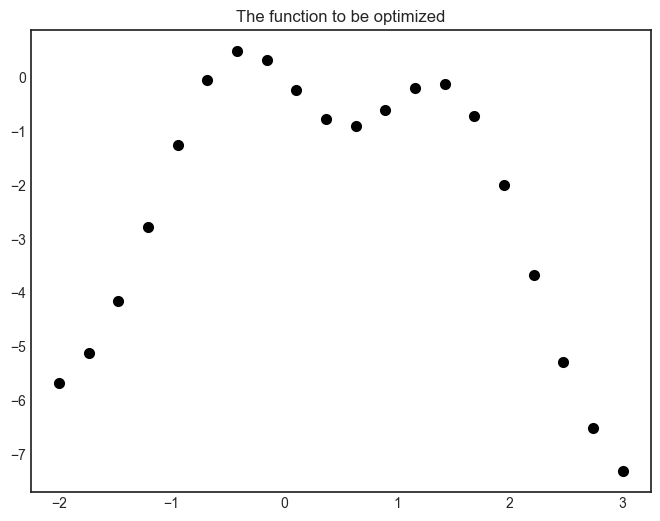

In [9]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 6))
    plt.scatter(train_x, train_y, c='k', linewidth=2)
    plt.title('The function to be optimized')
    plt.show()

### Next Experiment

In [10]:
def gen_next_point(init_x, init_y, best_init_y, bounds, n_points=1):
    
    """ 
    
    A Function to generate the next point to be evaluated.

    Args:
        init_x: The initial point
        init_y: The initial value of the function at the initial point
        best_init_y: The best value of the function seen so far
        bounds: The bounds of the function
        n_points: The number of points to generate

    Returns:
        candidate: Potential next candidate to be evaluated
    """

    model = SingleTaskGP(init_x, init_y)
    model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
    mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
    fit_gpytorch_model(mll)

    acquisition_func = acquisition.ExpectedImprovement(model=model, best_f= best_init_y)
    # acquisition_func = qExpectedImprovement(model=model, best_f= best_init_y)

    candidates, _ = optimize_acqf(acq_function=acquisition_func,
                                    bounds=bounds,
                                    q=n_points,
                                    num_restarts=200,
                                    raw_samples=512,
                                    options={'batch_limit': 5, 'maxiter': 100})
    
    print(f"The next point to be evaluated is {candidates}")

    return candidates


# bounds = torch.tensor([[-2.], [3.]])
# gen_next_point(train_x, train_y, best_observed_y, bounds)

### Optimization

In [12]:
n_runs = 30

init_x, init_y, best_observed_y = generate_initial_data(-2, 3, 20, 0)
bounds = torch.tensor([[-2.], [3.]])

# Dense grid of points within bounds
for i in range(n_runs):
    print(f"Nr. of Optimal Run: {i}")
    new_candidates = gen_next_point(init_x, init_y, best_observed_y, bounds, 1)
    new_results = target_function(new_candidates, 0).unsqueeze(-1)
    print(f"The new candidate are: {new_candidates}")

    init_x = torch.cat([init_x, new_candidates])
    init_y = torch.cat([init_y, new_results])

    best_observed_y = init_y.max().item()
    print(f"The best observed value is: {best_observed_y}")

C:\Users\majmo\AppData\Local\Temp\ipykernel_27444\3279724499.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y)


Nr. of Optimal Run: 0
The next point to be evaluated is tensor([[-0.3587]])
The new candidate are: tensor([[-0.3587]])
The best observed value is: 0.500356912612915
Nr. of Optimal Run: 1
The next point to be evaluated is tensor([[-0.3565]])
The new candidate are: tensor([[-0.3565]])
The best observed value is: 0.500356912612915
Nr. of Optimal Run: 2
The next point to be evaluated is tensor([[-0.3574]])
The new candidate are: tensor([[-0.3574]])
The best observed value is: 0.500356912612915
Nr. of Optimal Run: 3
The next point to be evaluated is tensor([[-0.3579]])
The new candidate are: tensor([[-0.3579]])
The best observed value is: 0.500356912612915
Nr. of Optimal Run: 4
The next point to be evaluated is tensor([[-0.3581]])
The new candidate are: tensor([[-0.3581]])
The best observed value is: 0.500356912612915
Nr. of Optimal Run: 5
The next point to be evaluated is tensor([[-0.3583]])
The new candidate are: tensor([[-0.3583]])
The best observed value is: 0.500356912612915
Nr. of Opt

In [14]:
train_x.shape

torch.Size([20, 1])

In [13]:
init_x.shape

torch.Size([50, 1])

### Compute posterior over test points and plot fit

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [18]:
lower_bound = -2
upper_bound = 3
num_of_points = 10
noise = 0

train_X, train_Y, best_observed_y = generate_initial_data(lower_bound, upper_bound, num_of_points, noise)

model = SingleTaskGP(train_X, train_Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
fit_gpytorch_model(mll)

# set model (and likelihood)
model.eval()

C:\Users\majmo\AppData\Local\Temp\ipykernel_27444\3279724499.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y)


SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-05)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)

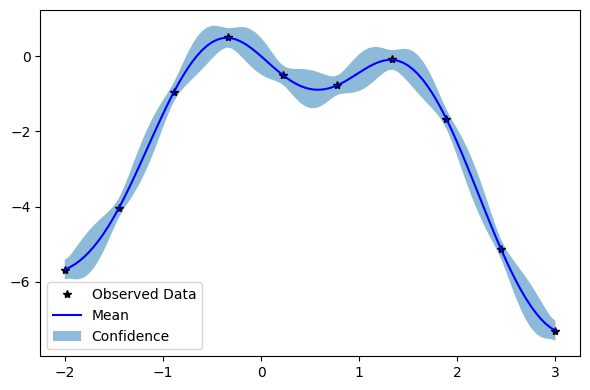

In [19]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(lower_bound, upper_bound, 101, dtype=dtype, device=device)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()

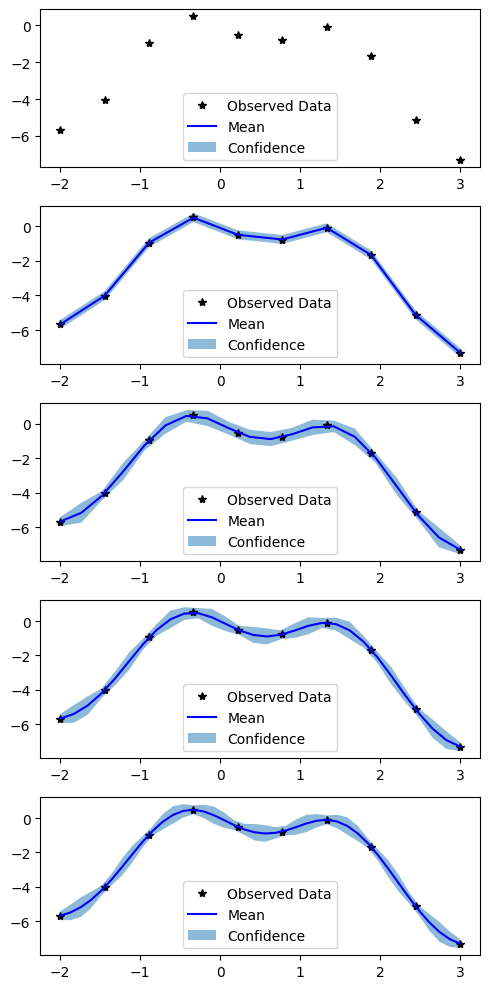

In [41]:
# Initialize plot
n_plot = len(list(range(0, 50, 10)))
fig, ax = plt.subplots(n_plot, figsize= (5, 10))
# test model on 101 regular spaced points on the interval [0, 1]
for idx, x_point in enumerate(range(0, 50, 10)):

    test_X = torch.linspace(lower_bound, upper_bound, x_point, dtype=dtype, device=device)
    # no need for gradients
    with torch.no_grad():
        # compute posterior
        posterior = model.posterior(test_X)
        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        # Plot training points as black stars
        ax[idx].plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'k*')
        # Plot posterior means as blue line
        ax[idx].plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax[idx].fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax[idx].legend(['Observed Data', 'Mean', 'Confidence'])
    plt.tight_layout()